In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
# Read data
dt=pd.read_csv("diabetic_data.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'diabetic_data.csv'

In [ ]:
# Categorical and Continuous data
print("There are ", len(dt.select_dtypes(include=['object']).columns), "object variables")
print("There are ", len(dt.select_dtypes(include=['int64']).columns), "continuous columns")

In [ ]:
# Check missing values
dt.isnull().values.any()

In [ ]:
# Check missing values through count
# Same information as above no missing values
dt.describe().columns[dt.describe().loc['count'] != dt.shape[0]]

In [ ]:
# Checking Duplicates
# dt[dt.duplicated()].count()
dt.duplicated().values.any()

In [ ]:
# Look at data
dt.head()

In [ ]:
# Replace '?' with NANs
dt.replace("?", np.nan, inplace=True)

In [ ]:
# Check missing values
dt.isnull().values.any()

In [ ]:
# checkin percentage of missing attribute per column
# Assuming 'df' is your DataFrame
missing_data = dt.isnull().mean() * 100  # Calculate the percentage of missing values per column

# Create a bar plot using Seaborn
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing_data.index, y=missing_data.values, palette='deep')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing (%)')
plt.title('Missing Values Percentage per Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Annotate the bars with percentage values (if greater than 0)
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.0f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',fontsize=9)
plt.show()

In [ ]:
# payers code, medical specialty, race, diagnosis 1, diagnosis 2 and diagnosis 3
# Remove ID variables, Weight
dt=dt.drop(["patient_nbr","encounter_id","weight"],axis=1)

In [ ]:
# Combining our targe to Yes and No instead of [No, >30, <30]
dup_data = dt.copy(deep=True)

# Update "readmitted" column
dup_data.loc[dup_data["readmitted"] == ">30", "readmitted"] = "YES"
dup_data.loc[dup_data["readmitted"] == "<30", "readmitted"] = "YES"

# Check unique values in "readmitted" column
print(dup_data["readmitted"].unique())

In [ ]:
age_id = {'[0-10)':5, 
          '[10-20)':15, 
          '[20-30)':25, 
          '[30-40)':35, 
          '[40-50)':45, 
          '[50-60)':55,
          '[60-70)':65, 
          '[70-80)':75, 
          '[80-90)':85, 
          '[90-100)':95}
dt['age'] = dt.age.replace(age_id)

## Looking to see correlation plot 

+ Checking correlation plot to see if we can use a variable that is correlated with our target variable to check those with the missing columns

In [ ]:
corr_matrix = dt.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(12, 6))  

# Create the correlation plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)

plt.xticks(rotation=45, ha='right')
plt.title('Correlation Plot')
plt.show()

**Relationships found per Corr plot**
+ Num of Medication and time in hospital
+ Lab procedures and time in hospital
+ Num procedures and num of medication
+ Num of diagnoses and num of medications
+ Num of diagnoses with time in hospital
+ Admission type  and num of procedures


# Using Semi-Supervise Algorithm to fill missing variables since relationships were found for the variables but there was not a third column that controlled it. They were missing completely at random

## >> Running a semi -supervised algorithm to imput medical_specialty since its missing completely at random

In [ ]:
inputed_df=pd.read_csv("SemiSupervised.csv")

In [ ]:
inputed_df=inputed_df.drop('total_diagnoses', axis=1)

# Fixing diag_1, diag_2 and diag_3

+ Get the max of the three set as 1 and rest 0 so <-- not a good idea removed

-- try these instead --
+ Count the amout of dignosis [250,na,5]->[1,0,1]
+ replacing nan to 0
 currently 2 df => flags, semi_supervised learning


In [ ]:
dt.columns

In [ ]:
#Couting the total diagnoses
columns_to_count = ['diag_1', 'diag_2', 'diag_3']

# Count non-null values for each row in the specified columns
dt["total_diagnoses"]=dt[columns_to_count].count(axis=1)
inputed_df["total_diagnoses"]=dt["total_diagnoses"]

In [ ]:
#Replacing with flag
dt.replace(np.nan, "miss", inplace=True)

In [ ]:
# Diag columns no longer have missing variables
# --> No missing variables!!!!!
inputed_df.isnull().sum().to_frame(name='counts').query('counts > 0')

# Earlier attempts at imputting [race, and payer_code]missing variables by finding patterns after looking throught the raw data

## >> Inputing Race
***Race Patterns***
+ Across all numeric variables caucasians have the lowest variance followed by African Americans then by hispanics,  others and Asians

Diagnoses
+ Caucasians have the ***highest mean*** of diagnoses of 7.53  with very low variability
+ Hispanics have the ***lowest mean*** 6.9 with a range going as low as 6.8 and high as 7
+ African Americans stick to 7.1 mean with low variability
+ Asians have the highest variability from 6.9 to 7.2 at a mean with 7
+ Other have almost a mean of 7.3 with some variabiity
Impatient 
+ Cacasians again have the lowest variability but sit at .64m mean second highest inpatient
+ The highest is African americans with .7

+ Number_impation  is 1 median for ***minorities*** on the group <30, African American, Asian and hispanic
+ Hispanics have 0 number of procedures for >30 and NO. Asisn <30 have a median procedure of 0
+ Race vs the rest of the continuous variables seems to not be all around the same median range
+ The group that gets readmitted the lowest is Asians 35% while Caucasians are the highest readmission with 46% followed by Affrican Americans with 45%
+ Time in hospital, num_lab_procedure, num_medications seem to be the only ones correlated with the different races
+ Disposition_id and readmission [<30,>30,NO] seem to have a relationship


In [ ]:
counts = dt.groupby(['race', 'readmitted']).size().unstack(fill_value=0)

# Calculate the percentages
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
ax = percentages.plot(kind='bar', figsize=(12, 4), stacked=True)

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='center')
    

plt.xlabel('Race')
plt.ylabel('Percentage')
plt.title('Percentage of Readmissions by Race')

plt.legend(title='Readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)

# Show the plot
plt.show()

In [ ]:
cont_df=dt.select_dtypes(exclude=['object'])
# Continues variable by race and readmission 
for i in cont_df.columns:
    plt.figure(figsize=(12, 3))  
    sns.pointplot(x='race', y=i, data=dt, hue='readmitted', dodge=True)  
    plt.title(f'Point Plot for {i} by Race and readmitted')  
    plt.xlabel('Race')  
    plt.ylabel(i)  
    plt.legend(title='Admission')  
    plt.show()  
    
    

+ Race has a relation with Time in hospital, num_lab_procedure, num_medications but chose mode Num_medication to impute missing variables since that has the highest variability

In [ ]:
from scipy.stats import chi2_contingency
import scipy
dt.loc[dt["readmitted"] == ">30", "readmitted"] = "YES"
dt.loc[dt["readmitted"] == "<30", "readmitted"] = "YES"

cross_tab=pd.crosstab(dt['race'], dt['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)

print(p)

In [ ]:
from scipy.stats import chi2_contingency
import scipy
chisqt = pd.crosstab(dt.race, dt.num_medications, margins=True)

value = np.array([chisqt.iloc[0][0:75].values,
                  chisqt.iloc[1][0:75].values,
                  chisqt.iloc[2][0:75].values,
                  chisqt.iloc[3][0:75].values,
                  chisqt.iloc[4][0:75].values
                 ])

chi2_stat, p_val, dof, expected = chi2_contingency(value)

print("Chi-squared statistic:", chi2_stat)
print("P-value:", p_val)
print("Degrees of freedom:", dof)


In [ ]:
race_by_numimp = dt.groupby(['readmitted', 'num_medications'])['race'].apply(lambda x: x.mode().iloc[0])

# Replace NA in "race" using race_by_numimp
for i in range(len(dt)):
    if pd.isna(dt.at[i, 'race']):
        readmitted_value = dt.at[i, 'readmitted'] 
        num_medications_value = dt.at[i, 'num_medications']
        if (readmitted_value, num_medications_value) in race_by_numimp.index:
            imputed_race = race_by_numimp.loc[(readmitted_value, num_medications_value)]
            dt.at[i, 'race'] = imputed_race

In [ ]:
dt["race"].isna().mean()
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

+ There is enough evidence to reject the null hypothesis of all races having equal number of medication (p_val=9.375516725969002e-48). We observed this relationship as well in the plots which why we are using this variable to impute missing valus in Race

## >> payer_code imputation


In [ ]:
dt['payer_code'].unique()

In [ ]:
dt.groupby('payer_code')['race'].value_counts(normalize=True).mul(100).round(1)

+ The users of OT have over 50% African americans

+ Looked at the raw data in excel and didn't find any pattens but though Age, Race and Insulin would have an influence as well as age vs Payer_code.
+ Therefore we plotted to see if there was any realationship between Payer code, age and race as well as age vs Payer_code but no emminent relationship found to help impute data.  

+ the median of age for all the races in the data with the missing payer_code is 65 year old.

***ultimatly no pattern was found thus will will replace missing variables for payer code with unique flag***

In [ ]:
dt[dt["payer_code"].isna()].groupby("race").median()

FR is an outlier so we can't use it to impute Payer_code
+ times in hospital =10 then Payer code is FR
+ num_lab_procedures >60  then Payer code is FR
+ num_medications  ==39 then Payer FR

+ A lot of African american look at their insuling have 34% as steady while the other races are 24-29%

In [ ]:
# sns.barplot(x="race", data= dt, hue="race")
# Create a strip plot
plt.figure(figsize=(16, 6))

sns.boxplot(x="payer_code", y="age", hue='race', data=dt)
plt.legend(title='readmitted', bbox_to_anchor=(1.05, 1), loc='upper left')



In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))

x, y, hue = "race", "percentage", "insulin"

# Create the bar plot
ax = sns.barplot(data=dt[hue]
        .groupby(dt[x])
        .value_counts(normalize=True)
        .mul(100)
        .round(1)
        .rename(y)
        .reset_index(), x=x, y=y, hue=hue)

# Add numbers on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


In [ ]:
l=pd.crosstab( dt['payer_code'],dt['race'],normalize='index')*100
l.plot(kind='bar', figsize=(14, 6)).legend(title='Payer Code', bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
dt['payer_code'].fillna('extra', inplace=True)

In [ ]:
dt["race"].isna().mean()
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

## >> Attempts at looking into medical_specialty to input values but we ended keeping the inputed values of the semi-supervised for this after looking at plots and running a random forest algor moved at the very end of the notebook since it only reached 50%  accuracy and 10% F1 score

In [ ]:
readmit = pd.crosstab(dt['medical_specialty'], dt['readmitted'])

# Calculate the percentage based on the sum of counts within each race group
readmit_percentage = readmit.div(readmit.sum(1), axis=0) * 100

readmit_percentage.sort_values(by='NO', ascending=False).head(5)

In [53]:
# Lets create a crosstab and find those that have a median of 15
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["num_medications"], aggfunc='median')
# Filter those columns were at least one category equal to 15
p[(p == 15).any(axis=1)]


readmitted,NO,YES
medical_specialty,,
Cardiology,15.0,16.0
Hematology/Oncology,14.0,15.0
Oncology,15.0,15.0
Otolaryngology,15.0,18.0
Pediatrics-Pulmonology,14.0,15.0
Podiatry,15.0,17.0
Pulmonology,13.0,15.0
Surgeon,15.0,16.0
Surgery-General,15.0,16.0


+ An option for the missing variables in medical_specialty would be
    - Yes "<30"=Could be(Family/GeneralPractice or InternalMedicine Surgeon)
    - Yes ">30"= Cardiology, Hospitalist, Pediatris-Pulmonology, Pulmonology or Surgery-PlasticWithinHeadandNeck
    - NO= Cardiology, Oncology, Otolaryngology, Podiatry, Surgeon or Surgery_general
+ However, we are aware there may not be a relationship 100% however better than guessing

In [54]:
p=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["number_diagnoses"], aggfunc='median')
# Too many options and no pattern was found
len(p[(p == 9).any(axis=1)])

# p.sort_values(by='NO', ascending=False).head(10)

24

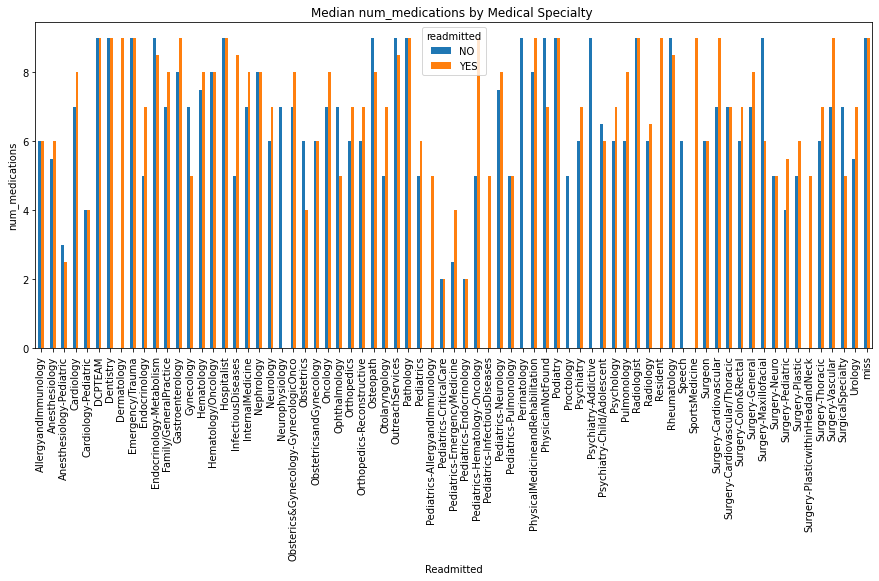

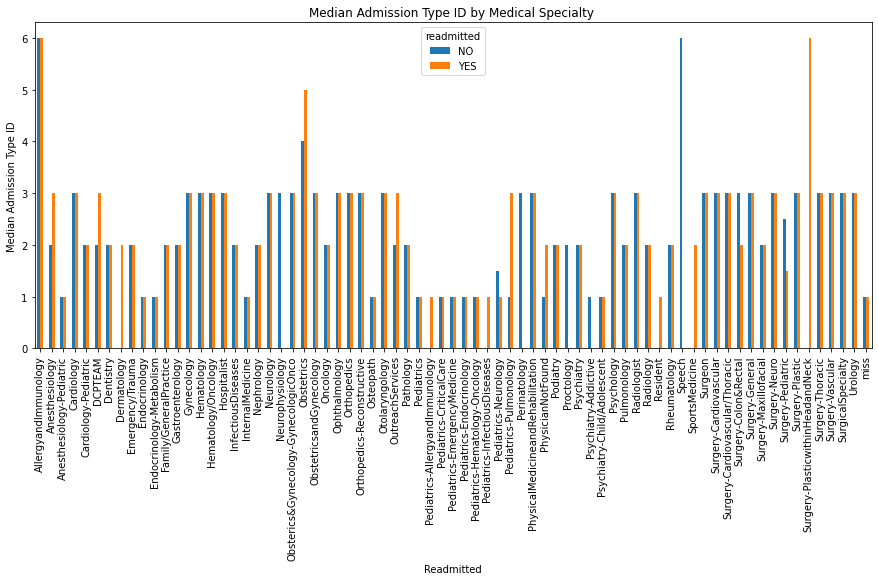

In [55]:
# Plot the transposed DataFrame
p.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('num_medications')
plt.title('Median num_medications by Medical Specialty ')

plt.show()

l=pd.crosstab(dt['medical_specialty'], dt['readmitted'], values=dt["admission_type_id"], aggfunc='median')

# Plot the transposed DataFrame
l.plot(kind='bar', figsize=(15, 6))  # You can adjust the figure size as needed

# Add labels and title
plt.xlabel('Readmitted')
plt.ylabel('Median Admission Type ID')
plt.title('Median Admission Type ID by Medical Specialty ')

plt.show()

In [56]:
# replace to flag
dt['medical_specialty'].fillna('missed', inplace=True)

# Chi Square

In [57]:
cross_tab = pd.crosstab(dt['race'], dt['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("The P-value for Race and readmitted chi square test ", p)

The P-value for Race and readmitted chi square test  3.693156699994485e-58


In [58]:
cross_tab = pd.crosstab(inputed_df['race'], inputed_df['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("Using the data imputted by Semi Supervised")
print("The P-value for Race and readmitted chi square test ", p)

Using the data imputted by Semi Supervised
The P-value for Race and readmitted chi square test  1.6997321730483784e-14


In [59]:
cross_tab = pd.crosstab(dt['age'], dt['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("The P-value for Age and readmitted chi square test ", p)

The P-value for Age and readmitted chi square test  5.1046708632083964e-48


In [60]:
cross_tab = pd.crosstab(inputed_df['age'], inputed_df['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("Using the data imputted by Semi Supervised")
print("The P-value for Race and readmitted chi square test ", p)

Using the data imputted by Semi Supervised
The P-value for Race and readmitted chi square test  9.348415309480624e-56


In [61]:
cross_tab = pd.crosstab(dt['gender'], dt['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("The P-value for Race and readmitted chi square test ", p)

The P-value for Race and readmitted chi square test  1.899934547488499e-08


In [62]:
cross_tab = pd.crosstab(inputed_df['gender'], inputed_df['readmitted'])
chi2, p, dof, expected = chi2_contingency(cross_tab)
print("Using the data imputted by Semi Supervised")
print("The P-value for Race and readmitted chi square test ", p)

Using the data imputted by Semi Supervised
The P-value for Race and readmitted chi square test  1.447272318868805e-07


# EDA
## Looking at the categorical variables

In [63]:
dt.select_dtypes(include=['object']).columns

Index(['race', 'gender', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

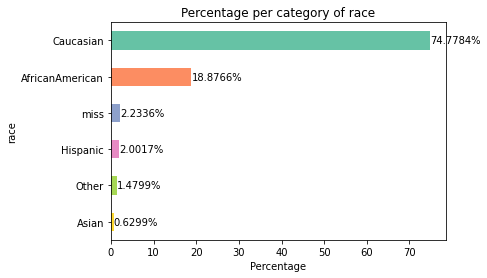

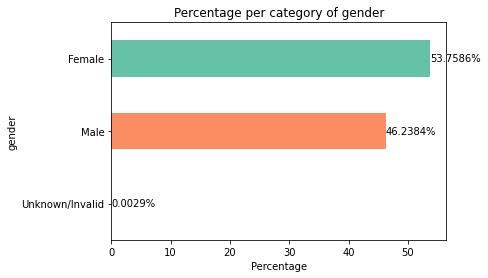

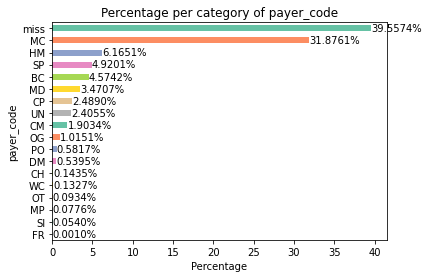

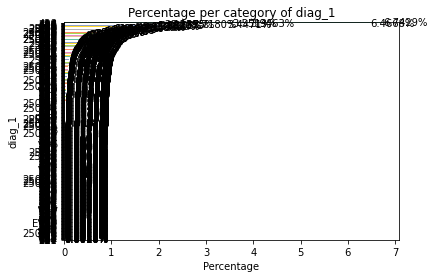

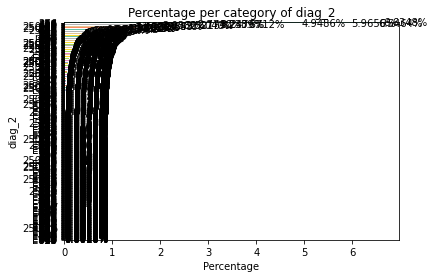

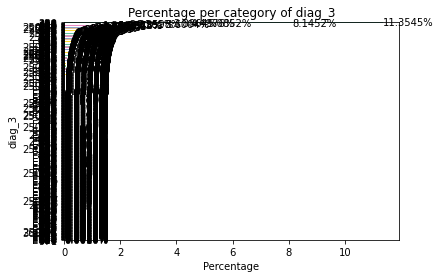

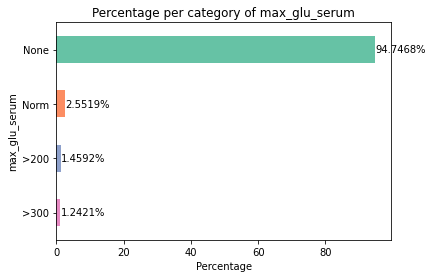

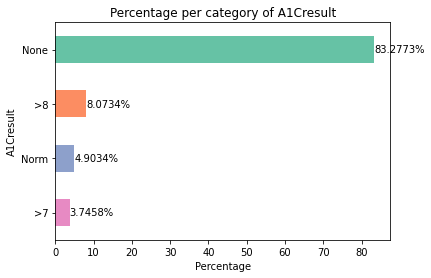

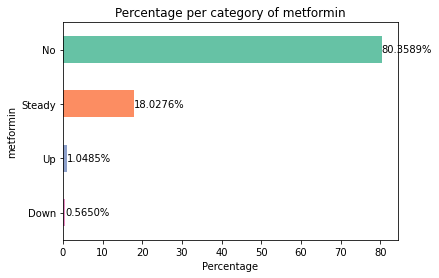

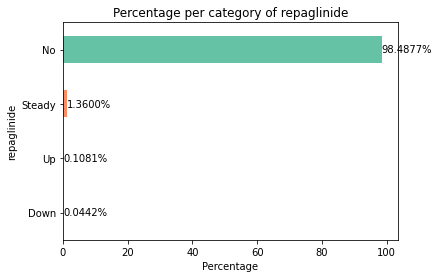

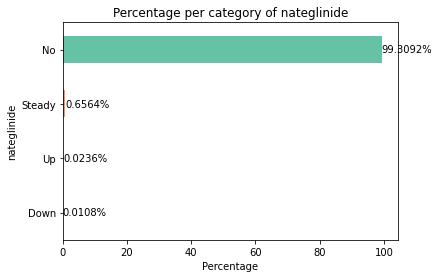

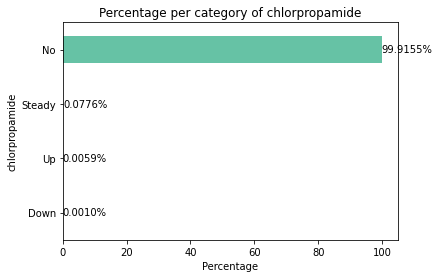

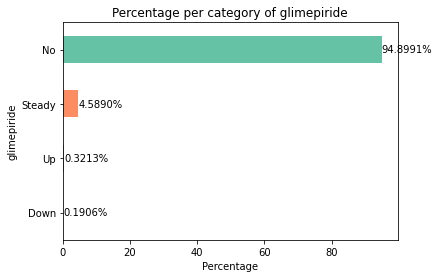

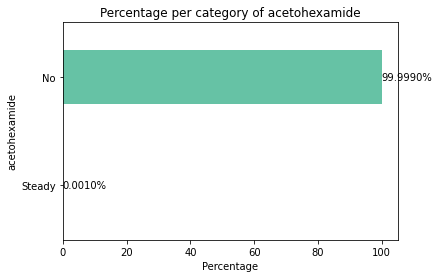

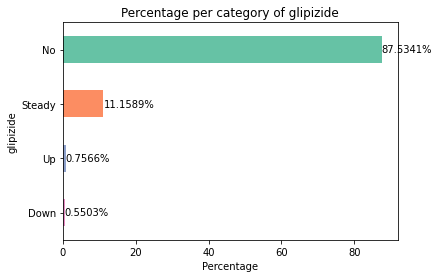

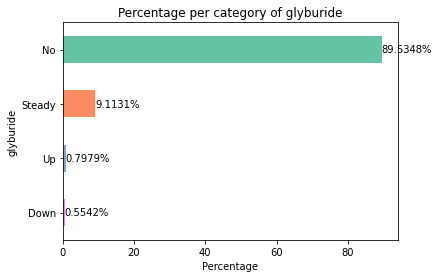

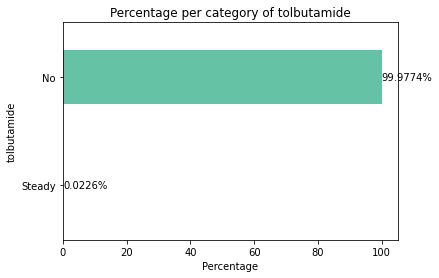

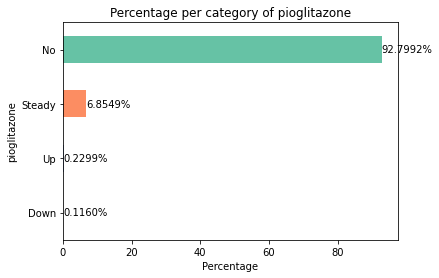

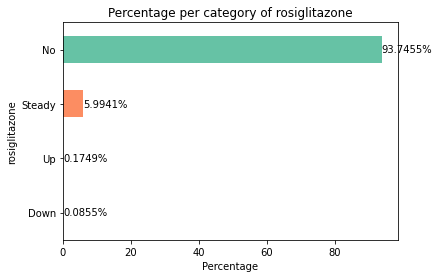

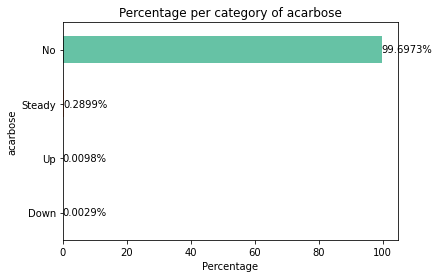

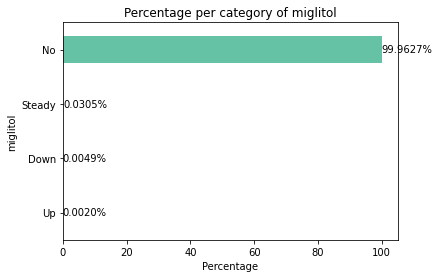

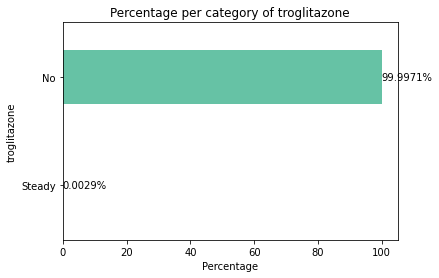

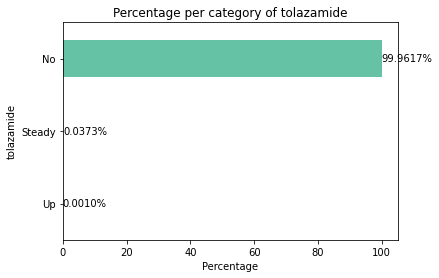

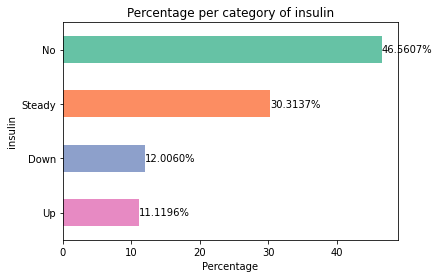

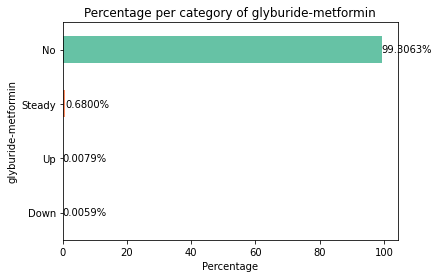

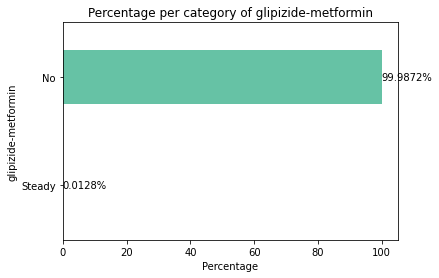

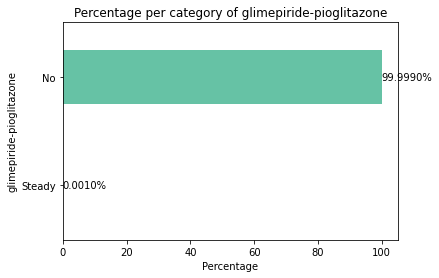

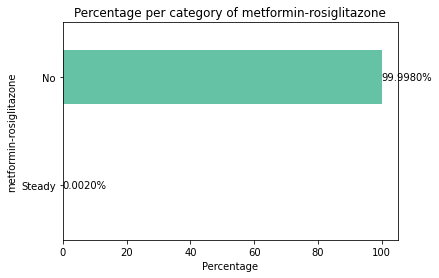

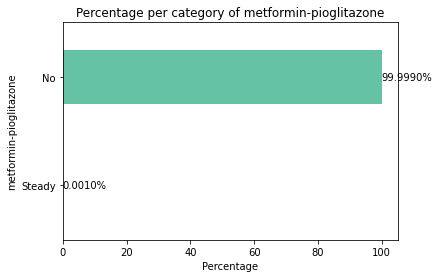

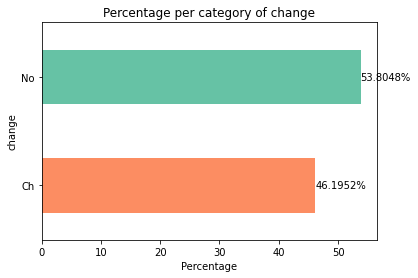

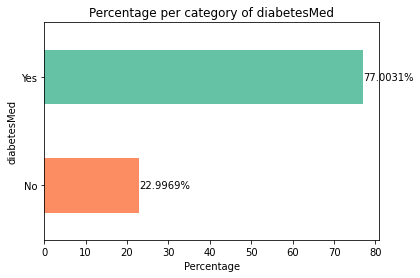

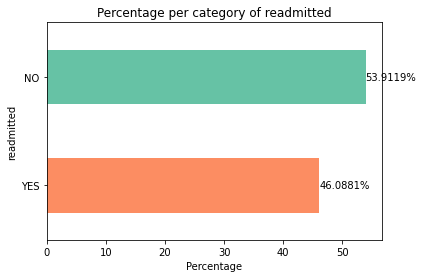

In [64]:
#Assuming 'data' is your DataFrame
cat_df = dt.select_dtypes(include=['object']).drop(["medical_specialty"], axis=1)

# Get the number of unique categories for each column
num_categories = cat_df.nunique()

# Define a color palette with as many colors as there are unique categories
color_palette = sns.color_palette("Set2", n_colors=num_categories.max())

for i in cat_df.columns:
    value_counts = dt[i].value_counts(normalize=True)
    colors = color_palette[:len(value_counts)]
    
    ax = value_counts.mul(100).plot(kind="barh", color=colors)
    
    plt.xlabel("Percentage")
    plt.ylabel(i)
    plt.title(f"Percentage per category of {i}")
    plt.gca().invert_yaxis()
    
    for index, value in enumerate(value_counts.mul(100)):
        ax.text(value, index, f'{value:.4f}%', ha='left', va='center', color='black')

    plt.show()
    
# Diabetes, change, metformin-piogitazone but flit no=yes could be turned into numeric


+ 76% is Caucasian
+ Age bucket is larger and ther is a correlation the older get hospitilized more 
+ Drop citoglipton and examide since the only value is "No"

In [50]:
# # Droping examide and citoglipton which only had 1 as the value
dt=dt.drop(dt[['examide','citoglipton']], axis=1)
inputed_df=inputed_df.drop(inputed_df[['examide','citoglipton']], axis=1)

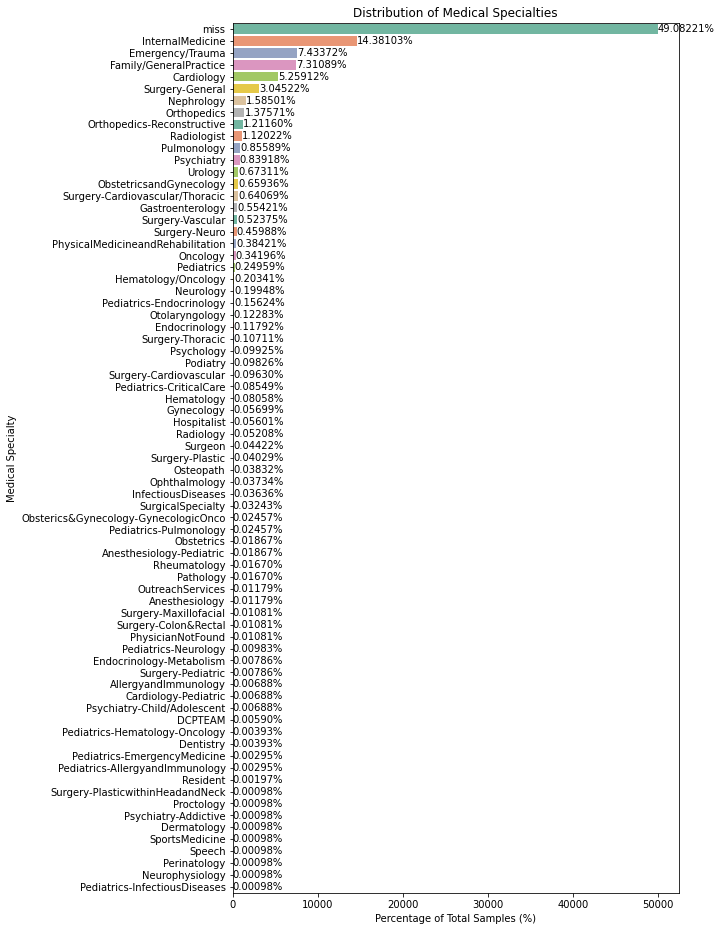

In [65]:
# Create a countplot of medical specialty percentages since it coudln't be printed above due to size
plt.figure(figsize=(8, 16))
sns.countplot(
    y=dt['medical_specialty'],
    orient='h',
    palette='Set2',
    order=dt['medical_specialty'].value_counts().index,  # Sort by count
)
plt.xlabel('Percentage of Total Samples (%)')
plt.ylabel('Medical Specialty')
plt.title('Distribution of Medical Specialties')

# Annotate the bars with percentage values
for p in plt.gca().patches:
    width = p.get_width()
    percentage = (width / len(dt)) * 100
    plt.gca().annotate(f'{percentage:.5f}%', (width + 1, p.get_y() + p.get_height() / 2), ha='left', va='center')

plt.show()


1: max diag ==1 rest 0 -->1,0,0
2: all ? to 0

## Looking a numeric variables
+ comments
+ admission_type_id -> Difference between 5 Not Available, 8 Not Mapped, 6 NULL
+ discharge_disposition_id -> 18 NULL, 25 Not Mapped, 26 Unknown/Invalid
+ admission_source_id-->9 NOT AVAILable, 15 NOT AVAILable ,17 NULL
+ Interesting num of medication is normaly distributed

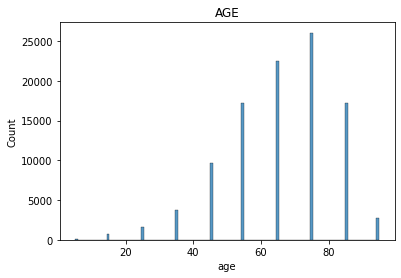

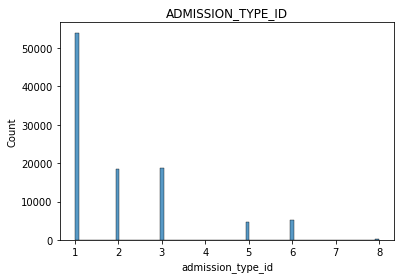

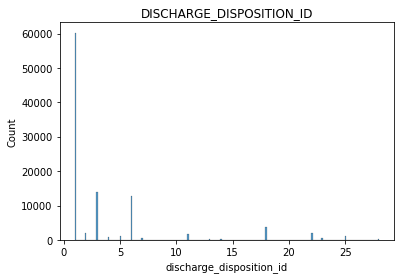

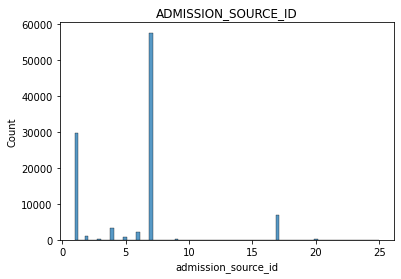

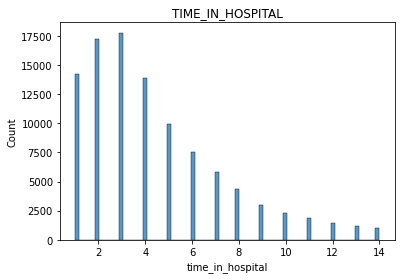

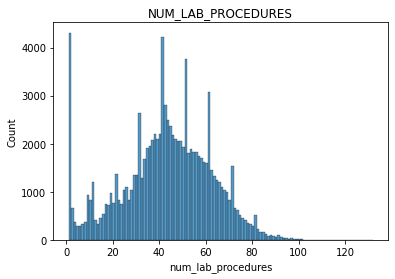

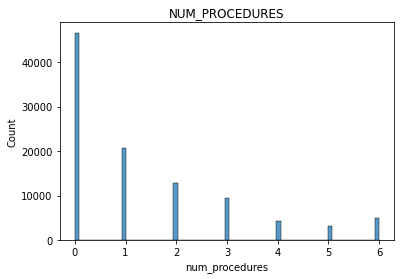

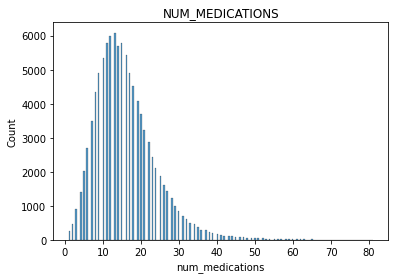

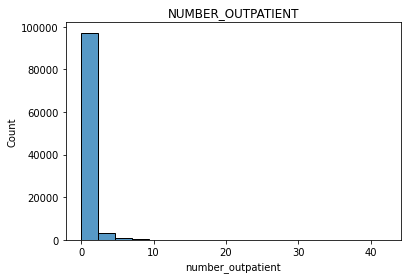

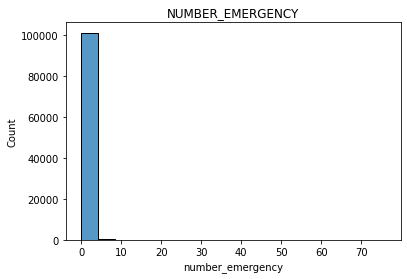

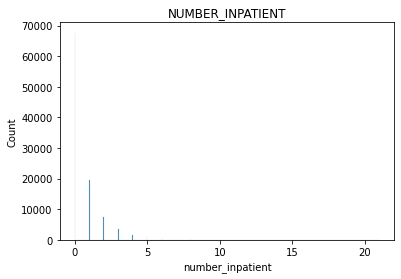

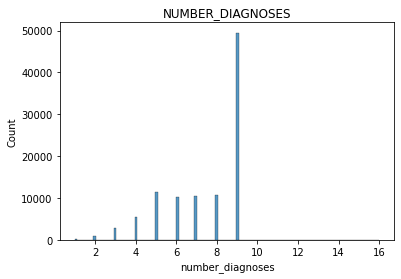

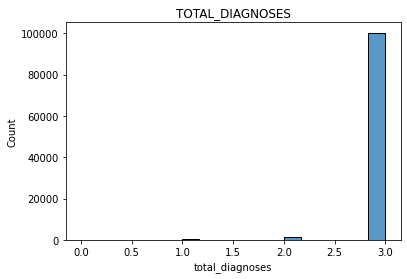

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in dt.select_dtypes(include=['int64']).columns:
    sns.histplot(dt[i],kde=False)
    plt.title(i.upper())
    plt.show()
    
#admission_type_id -> Difference between 5 Not Available, 8 Not Mapped, 6 NULL
#discharge_disposition_id -> 18 NULL, 25 Not Mapped, 26 Unknown/Invalid
#admission_source_id-->9 NOT AVAILable, 15 NOT AVAILable ,17 NULL
#num_procedures
#num_emergency

#interesting num of medication is normaly distributed

In [67]:
# variables are not normally distributed 
# Fixing variables for models as logistic regression requeres normal distribution

# Changing some variables as categories since they should be categories
num_to_cat=dt[['diag_1','diag_2','diag_3','admission_type_id','discharge_disposition_id','admission_source_id','number_emergency']]
for i in num_to_cat.columns:
    dt[i] = dt[i].astype('category')
    inputed_df[i] = inputed_df[i].astype('category')

# making age as continuous
dt['age'] = dt['age'].astype('int64')
inputed_df['age']= inputed_df['age'].astype('int64')

dt['time_in_hospital'] = dt['time_in_hospital'].replace(0, 0.0001)
dt['number_inpatient'] = dt['number_inpatient'].replace(0, 0.0001)
dt['number_outpatient'] = dt['number_outpatient'].replace(0, 0.0001)
dt['num_procedures'] = dt['num_procedures'].replace(0, 0.0001)

inputed_df['time_in_hospital'] = inputed_df['time_in_hospital'].replace(0, 0.0001)
inputed_df['number_inpatient'] = inputed_df['number_inpatient'].replace(0, 0.0001)
inputed_df['number_outpatient'] = inputed_df['number_outpatient'].replace(0, 0.0001)
inputed_df['num_procedures'] = inputed_df['num_procedures'].replace(0, 0.0001)

# Logging the 3 variables
for i in ['time_in_hospital','num_medications','age','number_inpatient','number_outpatient']:
    dt[i]=np.log(dt[i])
#     inputed_df[i]=np.log(inputed_df[i])

### changing from numeric to categoricalsince these are discrete:
+ 'diag_1','diag_2','diag_3','admission_type_id','discharge_disposition_id','admission_source_id','num_procedures','number_emergency'

### log 
- time_in_hospital
- num_medication
- age
*** distribution gets better but not normalized distribution***
- number_outpatient
- number_inpatient

### leave as is
- Num_lab_procedure


In [68]:
# Removing new variable but saving it in saved_totalDiag
saved_totalDiag=dt['total_diagnoses']
dt=dt.drop('total_diagnoses',axis=1)
inputed_df=inputed_df.drop('total_diagnoses',axis=1)

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit and transform only the numeric columns
numeric_columns = dt.select_dtypes(include=['number'])
dt[numeric_columns.columns] = scaler.fit_transform(numeric_columns)

# df_standardized = pd.DataFrame(scaler.fit_transform(dt), columns=dt.columns)

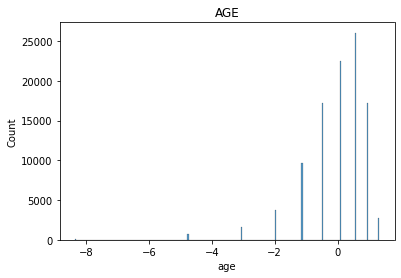

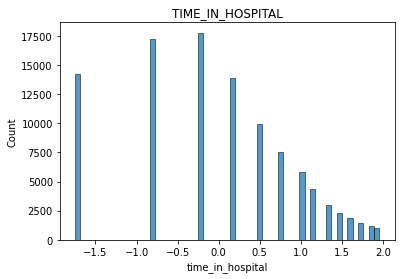

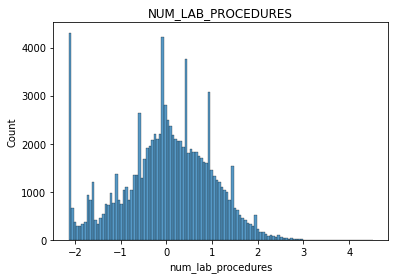

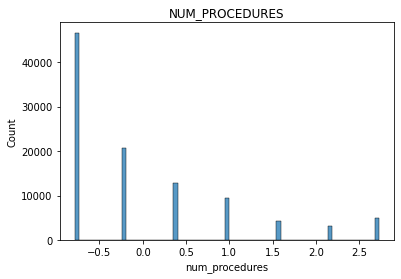

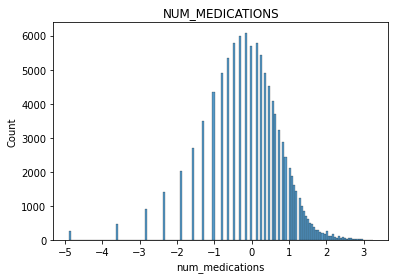

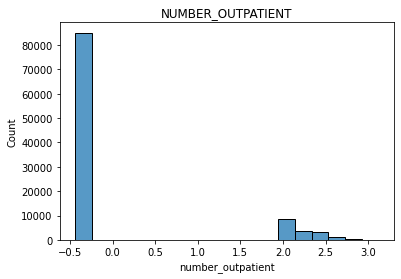

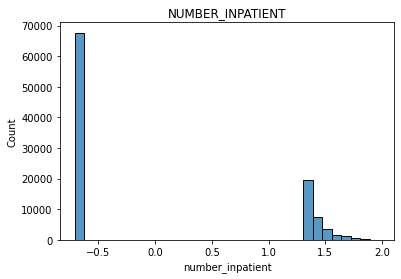

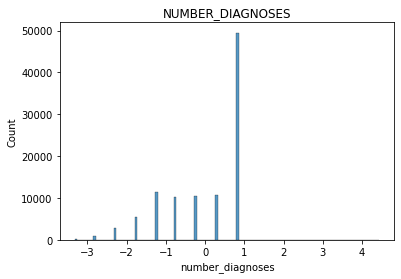

In [70]:
# Distribution after logged
for i in dt.select_dtypes(include=['float','int64']).columns:
    sns.histplot(dt[i],kde=False)
    plt.title(i.upper())
    plt.show()

In [71]:
# Categorical and Continuous data
print("There are ", len(dt.select_dtypes(include=['object','category']).columns), "object variables")
print("There are ", len(dt.select_dtypes(include=['float']).columns), "continuous columns")

There are  37 object variables
There are  8 continuous columns


***EDA completed***

# Run Model 

+ One hot encoding categorical variables

In [72]:
inputed_df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [73]:
# creating a list with all categorical 
categorical_columns=list(dt.select_dtypes(include=['object','category']).columns)
remove_col=['readmitted']
for i in remove_col:
    categorical_columns.remove(i)

# One-hot encode categorical columns

# With the inputed values from the semi supervise alg
model_dt_semiAlg = pd.get_dummies(inputed_df, columns=categorical_columns)

# With the imputed manual updates
# --> Medical_specialty with semi supervise, race using num_medication as reference and payer code with using a flag variable
model_dt_ManualUpdate=pd.get_dummies(dt, columns=categorical_columns)


In [74]:
# --> Change Readmitted to YES and NO 
model_dt_ManualUpdate.loc[model_dt_ManualUpdate["readmitted"] == ">30", "readmitted"] = "YES"
model_dt_ManualUpdate.loc[model_dt_ManualUpdate["readmitted"] == "<30", "readmitted"] = "YES"

model_dt_semiAlg.loc[model_dt_semiAlg["readmitted"] == ">30", "readmitted"] = "YES"
model_dt_semiAlg.loc[model_dt_semiAlg["readmitted"] == "<30", "readmitted"] = "YES"

### Running logistic regression  with manually imputted data

In [75]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split the data into features and target
X = model_dt_ManualUpdate.drop("readmitted",axis=1)
y = model_dt_ManualUpdate['readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

lr_noPenalty_Manual = LogisticRegression()
lr_noPenalty_Manual.fit(X_train, y_train)

y_pred = lr_noPenalty_Manual.predict(X_test)

class_report = classification_report(y_test, y_pred)

print(f'Classification Report:\n{class_report}')


/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Classification Report:
              precision    recall  f1-score   support

          NO       0.65      0.72      0.69     10973
         YES       0.63      0.55      0.59      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.64     20354
weighted avg       0.64      0.64      0.64     20354



### Running logistic regression  with SemiSupervised imputted data

In [ ]:
X_train_sm

In [77]:
# Split the data into features and target
X_semi = model_dt_semiAlg.drop("readmitted",axis=1)
y_semi = model_dt_semiAlg['readmitted']

X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_semi, y_semi, test_size=0.2, random_state=42, stratify=y)

lr_noPenalty_SM = LogisticRegression()
lr_noPenalty_SM.fit(X_train_sm, y_train_sm)

y_pred = lr_noPenalty_SM.predict(X_test_sm)

class_report = classification_report(y_test_sm, y_pred)

print(f'Classification Report:\n{class_report}')



/Users/lauraahumada/opt/anaconda3/envs/smuenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Classification Report:
              precision    recall  f1-score   support

          NO       0.64      0.75      0.69     10973
         YES       0.64      0.51      0.56      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.63     20354



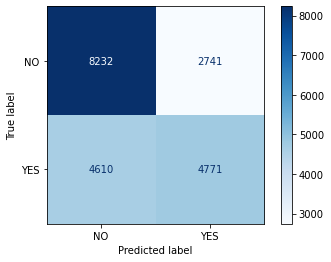

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test,y_pred, cmap='Blues')

In [79]:
len(X.columns)

2529

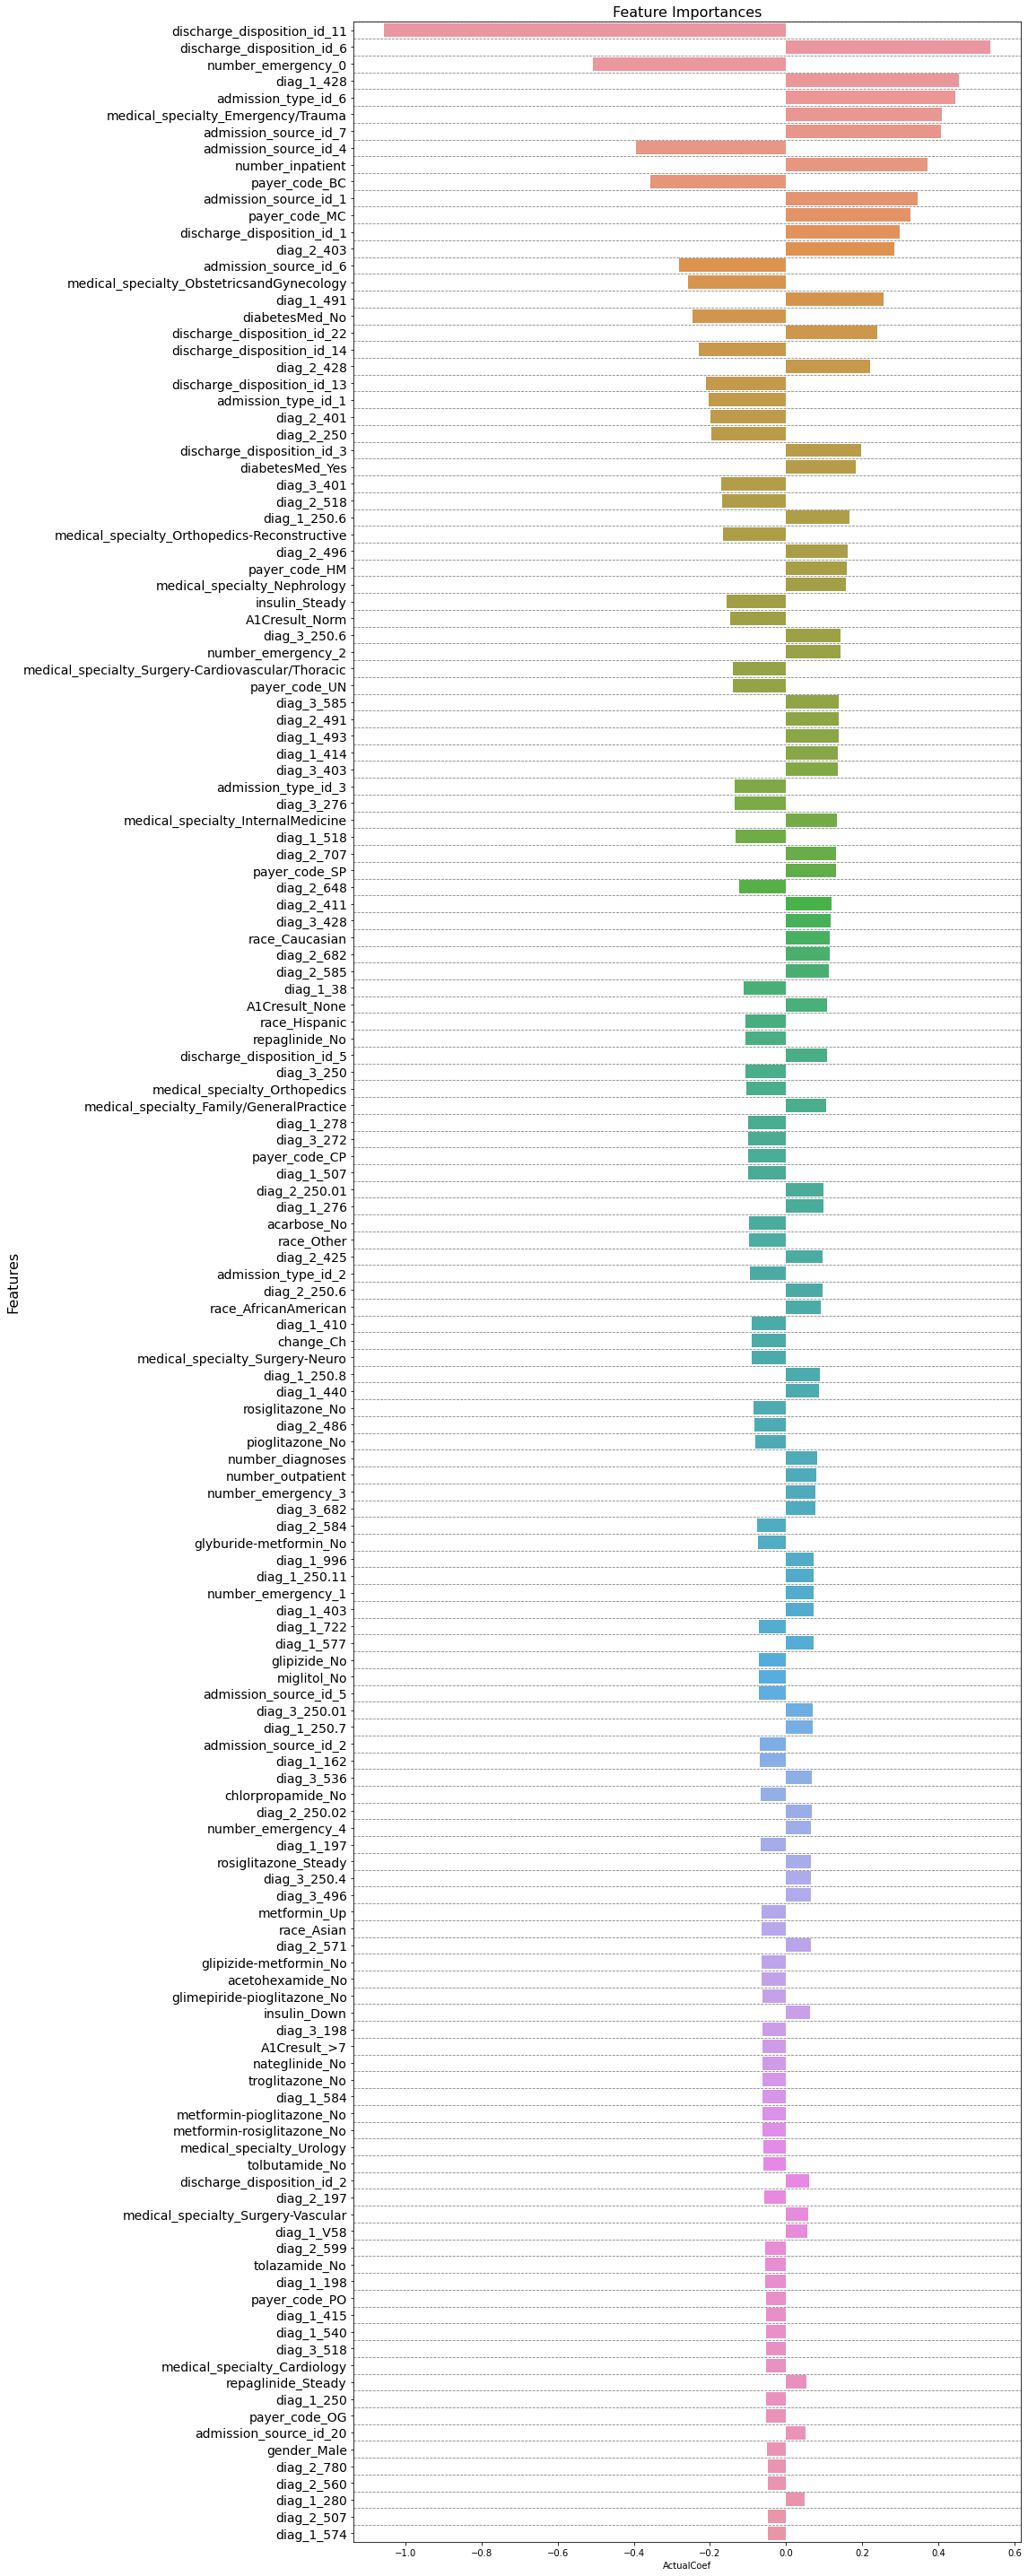

In [83]:
# Calculate feature importances (absolute values of coefficients)
importances = np.abs(lr_noPenalty_SM.coef_[0])
features = X_semi.columns

# Create a DataFrame to hold feature importances and sort it
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df["ActualCoef"]=lr_noPenalty_SM.coef_[0]
importance_df=importance_df.sort_values(by='Importance', ascending=False)
importance_df=importance_df.head(150)
# importance_df = importance_df.sort_values(by='Importance', ascending=False).index

plt.figure(figsize=(16, 40))  

# Set the style to have a white background
plt.style.use('default')  # Use the default style
sns.barplot(y=importance_df["Feature"], x=importance_df["ActualCoef"])

plt.title('Feature Importances', fontsize=16) 
plt.ylabel('Features', fontsize=16) 

tick_positions = range(len(importance_df["Feature"]))
tick_labels = importance_df["Feature"]
plt.yticks(tick_positions, tick_labels, fontsize=14) 

for pos in tick_positions:
    plt.axhline(y=pos - 0.5, color='gray', linestyle='--', linewidth=0.8)

plt.tight_layout()

plt.show()


### L1 SemiSupervised

In [84]:
l1_model = LogisticRegression(penalty='l1', solver='liblinear')
l1_model.fit(X_train_sm, y_train_sm)

y_pred = l1_model.predict(X_test_sm)

class_report = classification_report(y_test_sm, y_pred)

print(f'Classification Report:\n{class_report}')

Classification Report:
              precision    recall  f1-score   support

          NO       0.65      0.73      0.69     10973
         YES       0.63      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.64      0.63     20354
weighted avg       0.64      0.64      0.64     20354



### L2 Manually updated variables

In [85]:
l2_model = LogisticRegression(penalty='l2', solver='liblinear')
l2_model.fit(X_train, y_train)

y_pred = l2_model.predict(X_test)

class_report = classification_report(y_test, y_pred)

print(f'Classification Report:\n{class_report}')

Classification Report:
              precision    recall  f1-score   support

          NO       0.65      0.72      0.68     10973
         YES       0.62      0.55      0.59      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354



### L1 model with different C variables

+ at C=1.0 the best recall is obtained  at 10 it gives same recall for Yes but lower for No

In [86]:
# Define a list of C values to test
C_values = [0.1, 1.0, 10.0]  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_semi, y_semi, test_size=0.2, random_state=42, stratify=y)


for C in C_values:
    l2_model = LogisticRegression(penalty='l2', solver='liblinear', C=C)
    l2_model.fit(X_train_sm, y_train_sm)
    
    y_pred = l2_model.predict(X_test_sm)
    
    class_report = classification_report(y_test_sm, y_pred)
    
    print(f'Classification Report for C={C}:\n{class_report}')


Classification Report for C=0.1:
              precision    recall  f1-score   support

          NO       0.65      0.75      0.69     10973
         YES       0.64      0.53      0.58      9381

    accuracy                           0.65     20354
   macro avg       0.65      0.64      0.64     20354
weighted avg       0.65      0.65      0.64     20354

Classification Report for C=1.0:
              precision    recall  f1-score   support

          NO       0.65      0.73      0.69     10973
         YES       0.63      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.63     20354
weighted avg       0.64      0.64      0.64     20354

Classification Report for C=10.0:
              precision    recall  f1-score   support

          NO       0.65      0.72      0.68     10973
         YES       0.63      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64     

+ L2 model with different C variables

In [87]:
# Define a list of C values to test
C_values = [0.01,0.1, 1.0,3.0]  

for C in C_values:
    l2_model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    l2_model.fit(X_train, y_train)
    
    y_pred = l2_model.predict(X_test)
    
    class_report = classification_report(y_test, y_pred)
    
    print(f'Classification Report for C={C}:\n{class_report}')


Classification Report for C=0.01:
              precision    recall  f1-score   support

          NO       0.63      0.79      0.70     10973
         YES       0.65      0.46      0.54      9381

    accuracy                           0.64     20354
   macro avg       0.64      0.63      0.62     20354
weighted avg       0.64      0.64      0.63     20354

Classification Report for C=0.1:
              precision    recall  f1-score   support

          NO       0.65      0.76      0.70     10973
         YES       0.65      0.52      0.58      9381

    accuracy                           0.65     20354
   macro avg       0.65      0.64      0.64     20354
weighted avg       0.65      0.65      0.64     20354

Classification Report for C=1.0:
              precision    recall  f1-score   support

          NO       0.65      0.73      0.69     10973
         YES       0.63      0.54      0.58      9381

    accuracy                           0.64     20354
   macro avg       0.64     

### Cross validation L1 and L2 changing C

In [ ]:
# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import StratifiedKFold, cross_validate

# C_values = [3.0,5.0]  

# scoring = ['precision_macro', 'recall_macro']
# sk_folds = StratifiedKFold(n_splits = 10)
# c_Scores_list=[]


# for C in C_values:
#     lrs_l2=LogisticRegression(penalty='l2', solver='liblinear', C=C)
#     lrs_l1=LogisticRegression(penalty='l1', solver='liblinear', C=C)
    
    
#     cvs2 = cross_validate(lrs_l2, X, y,  scoring=scoring, cv = sk_folds)
#     cvs1 = cross_validate(lrs_l1, X, y, scoring=scoring, cv = sk_folds)

#     c_Scores_list.append([C,np.mean(cvs1['test_recall_macro']),np.mean(cvs2['test_recall_macro'])])
#     print(C, " Completed")
    
# # Best Average recall CV Score L2:  0.6285113641779668  for C= 0.1
# # Best Average recall CV Score L1:  0.6284716266172024  for C= 0.1

# # -->> error because it was stopped at 1.0 as it was taking too much time
# # RESULTS OBTAINED
# # Average recall CV Score L1:  0.6207392615741109  for C= 0.01
# # Average precision CV Score L1:  0.6317275862519797  for C= 0.01
# # Average recall CV Score L2:  0.6271450448699474  for C= 0.01
# # Average precision CV Score L2:  0.6375759936573075  for C= 0.01
# # Average recall CV Score L1:  0.6284716266172024  for C= 0.1
# # Average precision CV Score L1:  0.637805223443547  for C= 0.1
# # Average recall CV Score L2:  0.6285113641779668  for C= 0.1
# # Average precision CV Score L2:  0.6365838523717404  for C= 0.1
# # Average recall CV Score L1:  0.6278999910250957  for C= 1.0
# # Average precision CV Score L1:  0.6351392050343468  for C= 1.0
# # Average recall CV Score L2:  0.6273127219851374  for C= 1.0
# # Average precision CV Score L2:  0.6341212525499211  for C= 1.0

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold, cross_validate

l_r = LogisticRegression()
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty':['l1','l2']}

splitter = StratifiedKFold(n_splits = 10)

lasso_grid_search = GridSearchCV(estimator=l_r, param_grid=params, cv=splitter, n_jobs=-1, scoring='recall')

# Fit the grid search to your data
lasso_grid_search.fit(X, y)

# Get the best recall score and best C value
best__score = lasso_grid_search.best_score_
best__C = lasso_grid_search.best_params_['C']
best__penalty = lasso_grid_search.best_params_['penalty']
best__model = lasso_grid_search.best_estimator_

# Print the results
print(f"Best Recall Score: {best__score:.4f}")
print(f"Best C Value: {best__C}")
print(f"Best Penalty: {best__penalty}")
print(f"Best Lasso Model: {best__model}")


# Running the model with best C and Penalty

In [ ]:
l1_C1_SM= LogisticRegression(penalty='l2', solver='liblinear')
l1_C1_SM.fit(X_train_sm, y_train_sm)

y_pred = l1_C1_SM.predict(X_test_sm)

class_report = classification_report(y_test_semi, y_pred)

print(f'Classification Report:\n{class_report}')

In [ ]:
l1_C1= LogisticRegression(penalty='l2', solver='liblinear')
l1_C1.fit(X_train, y_train)

y_pred = l1_C1.predict(X_test)

class_report = classification_report(y_test, y_pred)

print(f'Classification Report:\n{class_report}')

### Printing ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc

# Predict the probability of the positive class
y_prob = logisticRegression_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for linear regression')
plt.legend(loc='lower right')
plt.show()


#### Comparing Orginal L1 to adjuste L1 with 

In [ ]:
# comparing 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for L1 and L2 models
y_prob_SM = lr_noPenalty_SM.predict_proba(X_test)[:, 1]
y_prob_ = lr_noPenalty_Manual.predict_proba(X_test_sm)[:, 1]
y_prob_C_SM = l1_C1_SM.predict_proba(X_test)[:, 1]
y_prob_C_ = l1_C1.predict_proba(X_test_sm)[:, 1]

# Calculate the ROC
fpr_SM, tpr_SM, _ = roc_curve(y_test_sm, y_prob_SM)
roc_auc_SM = auc(fpr_SM, tpr_SM)

fpr_, tpr_, _ = roc_curve(y_test, y_prob_)
roc_auc_ = auc(fpr_, tpr_)

fpr_C_SM, tpr_C_SM, _ = roc_curve(y_test_C_sm, y_prob_SM)
roc_auc_C_SM = auc(fpr_SM, tpr_SM)

fpr_C, tpr_C, _ = roc_curve(y_test_C, y_prob_)
roc_auc_C = auc(fpr_C, tpr_C)




# Create the ROC curve plot
plt.figure(figsize=(10, 8))
plt.plot(fpr_SM, tpr_SM, color='darkorange', lw=2, label=f'ROC curve (lr_noPenalty_SM, AUC = {roc_auc_SM:.2f})')
plt.plot(fpr_, tpr_, color='blue', lw=2, label=f'ROC curve (lr_noPenalty_Manual, AUC = {roc_auc_:.2f})')
plt.plot(fpr_C_SM, tpr_C_SM, color='green', lw=2, label=f'ROC curve (l1_C1_SM, AUC = {roc_auc_C_SM:.2f})')
plt.plot(fpr_C, tpr_C, color='red', lw=2, label=f'ROC curve (l1_C1, AUC = {roc_auc_C:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc='lower right')
plt.show()



In [81]:

from sklearn.metrics import roc_curve, auc

C_values = [0.001, 0.01, 0.1, 1, 10, 100]  
X_train, X_test, y_train, y_test = train_test_split(X_semi, y_semi, test_size=0.2, random_state=42, stratify=y)

# Initialize lists to store ROC curve data
roc_curves_l1 = []
roc_curves_l2 = []

# Fit logistic regression models with L1 and L2 regularization
l1_model = LogisticRegression(penalty='l1', C= ,solver='liblinear')
l2_model = LogisticRegression(penalty='l2', C=,solver='liblinear')

l1_model.fit(X_train, y_train)
l2_model.fit(X_train, y_train)

l1_y_prob = l1_model.predict_proba(X_test)[:, 1]
    fpr_l1, tpr_l1, _ = roc_curve(y_test, l1_y_prob)

    
    roc_curves_l1.append((fpr_l1, tpr_l1, C))
    roc_curves_l2.append((fpr_l2, tpr_l2, C))

plt.figure(figsize=(8, 6))
for fpr, tpr, C in roc_curves_l1:
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (L1, C={C})')

# Plot ROC curves for L2
for fpr, tpr, C in roc_curves_l2:
    plt.plot(fpr, tpr, lw=2, linestyle='--', label=f'ROC curve (L2, C={C})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for L1 and L2 Regularization')
plt.legend(loc='lower right')
plt.show()


SyntaxError: invalid syntax (3535031417.py, line 11)

In [ ]:
# Using Manual update df
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_semi, y_semi, test_size=0.2, random_state=42, stratify=y)
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

class_report = classification_report(y_test, y_pred)


print(f'Classification Report:\n{class_report}')


+ remember ---> talk about using gender,race and age in data at the end

# Extra
# ----->  That was not used

## Running Random Forest to replacing missing medical_specialty values

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

# # creating a list with all categorical varible excluding Medical specialty
# categorical_columns=list(dt.select_dtypes(include=['object']).columns)
# categorical_columns.remove("medical_specialty")

# # One-hot encode categorical columns
# data_encoded = pd.get_dummies(dt, columns=categorical_columns)

# #saving the hot encoded features with missing medical specialty for later
# unlabeled_X=data_encoded[data_encoded["medical_specialty"].isnull()].drop("medical_specialty",axis=1)
# print(unlabeled_X.shape," Missing variables medical_specialty")

# # Removing all the rows with Medical Specialty missing
# data_encoded=data_encoded.dropna(subset=["medical_specialty"])
# print(data_encoded.shape, " without Missing variables medical_specialty")

# X_=data_encoded.drop("medical_specialty", axis=1)
# y_=data_encoded["medical_specialty"]

# X_train,X_test, Y_train, Y_test=train_test_split(X_,y_, test_size=0.2, random_state=42)
# rm=RandomForestClassifier()

# rm.fit(X_train, Y_train)

# pr=rm.predict(X_test)

# print('Accuracy:',accuracy_score(Y_test, pr))

In [ ]:
# # Having built the model predict on the actual missing data
# missing_MS=rm.predict(unlabeled_X)
# missing_MS=list(missing_MS)

# # Replaced nul values with predicted values from Randm forest
# dt["medical_specialty"]=dt.apply(lambda row: missing_MS.pop(0) if pd.isna(row["medical_specialty"]) else row["medical_specialty"], axis=1)
# dt["medical_specialty"].isnull().mean() 

In [ ]:
# Medical_specialty is no longer has missing variables
dt.isnull().sum().to_frame(name='counts').query('counts > 0')

In [ ]:
#--> commented out it should be continuous, left as is
# Changing time in hospital to bins
# inputed_df['time_in_hospital']=pd.cut(inputed_df["time_in_hospital"], bins=[0, 2, 5, 10, np.inf], labels=["Short", "Medium", "Long", "Very Long"])